## Testing with param

Providing `model` parameters and name, running simulation to produce energy deposition vs. time plot.

In [1]:
%env ASTERIA=/home/jakob/software/ASTERIA/ASTERIA
from asteria.simulation import Simulation
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq

env: ASTERIA=/home/jakob/software/ASTERIA/ASTERIA


/usr/local/lib/python3.8/dist-packages/tqdm-4.65.0-py3.8.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
include_wls = False

In [3]:
def moving_average(a, n=3, zero_padding = False, const_padding = False):
    if zero_padding:
        ind = np.arange(n-1)
        a = np.insert(a, ind, np.zeros(n-1))
        a = np.roll(a, -int((n-1)/2))
    if const_padding:
        if n%2 != 1:
            ind1 = np.arange((n-1)/2).astype(int)
            ind2 = -np.arange(1,(n-1)/2).astype(int)
            a = np.insert(a, ind1, np.ones(int((n/2)))*a[0])
            a = np.insert(a, ind2, np.ones(int((n-1)/2))*a[-1])
        else:
            ind1 = np.arange((n-1)/2).astype(int)
            ind2 = -np.arange(1,(n+1)/2).astype(int)
            a = np.insert(a, ind1, np.ones(int((n-1)/2))*a[0])
            a = np.insert(a, ind2, np.ones(int((n-1)/2))*a[-1])
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [4]:
#Returns binning needed to resolve a frequency.
def get_binning(sim, dt, frequency=80*u.Hz): 
    duration = sim.time[-1]-sim.time[0]
    samples = (duration/dt.to(u.s)).value
    return int((1/frequency*samples/duration).value) #binning needed to filter out sinals with f>f_lb_sasi

In [5]:
# Binning of the moving average filter defined by the Nyquist frequency of the SASI modulation
# If the sampling was to be finer the binning could be done finer, however this comes at the expense of lower
# statistics. Therefore we keep the sampling rate at 1 ms.

def get_average_signal(sim, dt, distance, frequency=80*u.Hz):
    binning = get_binning(sim, dt, frequency)

    #detector_signal s0 is not drawn from distribution
    t, s0_i3 = sim.detector_signal(dt=dt, subdetector='i3')
    t, s0_dc = sim.detector_signal(dt=dt, subdetector='dc')
    t, s0_md = sim.detector_signal(dt=dt, subdetector='md')

    s0_ic86 = s0_i3 + s0_dc
    s0_gen2 = s0_i3 + s0_dc + s0_md
    t = t.to(u.ms)

    #averaged signal sa binning size defined by the Nyquist frequency of the SASI modulation and constant padding
    sa_ic86 = moving_average(s0_ic86, n=binning, const_padding=True)
    sa_gen2 = moving_average(s0_gen2, n=binning, const_padding=True)
    
    return sa_gen2, sa_ic86

In [6]:
dt = 0.1*u.ms # highest frequency in Tamborra 2014 model

model = {'name': 'Tamborra_2014',
         'param':{
             'progenitor_mass': 20*u.Msun}
         }
sim = Simulation(model=model,
                 distance=10* u.kpc, 
                 Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                 tmin=0.006*u.s, tmax=0.338*u.s, dt=dt,
                 hierarchy = 'normal',
                 mixing_scheme = 'NoTransformation',
                 geomscope = 'Gen2',
                 include_wls = include_wls)
sim.run()

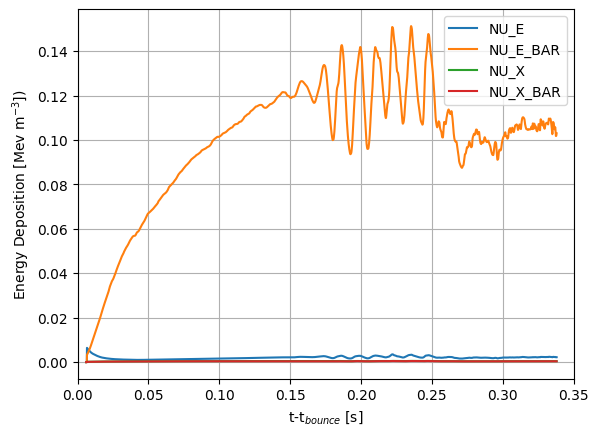

In [7]:
for flavor in sim.flavors:
    plt.plot(sim.time, sim.E_per_V[flavor], label=flavor.name)
plt.legend()
ax = plt.gca()
ax.set(xlabel=r't-t$_{bounce}$ [s]', ylabel='Energy Deposition [Mev m$^{-3}$])', xlim=(0, 0.35))
ax.grid()

In [8]:
dt = 1 * u.ms
ana_wind = [100, 300] * u.ms
cut_freq = 75 * u.Hz

In [9]:
#average background given by the mean of the sensor distribution and scaled to the full detector
ba_ic86 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu)*dt/(1*u.s)
ba_gen2 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu + sim.detector.n_md*sim.detector.md_bg_mu)*dt/(1*u.s)

In [10]:
def signal_processing(sim, dt, distance, trials, 
                      return_raw=False,
                      return_fourier=False, 
                      return_power=False, 
                      return_max_power=False,
                      return_significance=False):

    # scale simulation with distance
    sim.scale_result(distance=distance)
    
    sa_gen2, sa_ic86 = get_average_signal(sim, dt=dt, distance=distance)
    
    # time and signal realization for each detector component
    t, s_i3 = sim.detector_hits(dt=dt, subdetector='i3', size=trials)
    t, s_dc = sim.detector_hits(dt=dt, subdetector='dc', size=trials)
    t, s_md = sim.detector_hits(dt=dt, subdetector='md', size=trials)
    #t, s_ws = sim.detector_hits(dt=dt, subdetector='ws')
    t = t.to(u.ms)

    # random background realization
    b_i3 = sim.detector.i3_bg(dt=dt, size=s_i3.shape[1]*trials)
    b_dc = sim.detector.dc_bg(dt=dt, size=s_dc.shape[1]*trials)
    b_md = sim.detector.md_bg(dt=dt, size=s_md.shape[1]*trials)
    #b_ws = sim.detector.ws_bg(dt=dt, size=len(s_ws)*trials)
    
    # reshape background
    b_i3 = b_i3.reshape(trials,s_i3.shape[1])
    b_dc = b_dc.reshape(trials,s_dc.shape[1])
    b_md = b_md.reshape(trials,s_md.shape[1])

    ### SIGNAL TRIALS ###
    s_ic86 = s_i3 + s_dc
    s_gen2 = s_i3 + s_dc + s_md
    b_ic86 = b_i3 + b_dc
    b_gen2 = b_i3 + b_dc + b_md

    # combined signal S: signal + background
    S_ic86 = s_ic86 + b_ic86
    S_gen2 = s_gen2 + b_gen2
    
    
    mask = np.logical_and(t>=ana_wind[0], t<=ana_wind[1])
    tf = t[mask]
    N = len(tf)
    T = sim._res_dt.value
      
    #Fourier transformation
    Sf_ic86 = 2.0/N * np.abs(fft(S_ic86[:,mask], axis = -1)[:,1:N//2])
    Sf_gen2 = 2.0/N * np.abs(fft(S_gen2[:,mask], axis = -1)[:,1:N//2])
    f = fftfreq(N,T)[1:N//2]

    #Power spectrum
    Sp_ic86 = Sf_ic86**2
    Sp_gen2 = Sf_gen2**2
    
    Sm_ic86 = np.max(Sp_ic86[:,f>cut_freq.value], axis=-1)
    Sm_gen2 = np.max(Sp_gen2[:,f>cut_freq.value], axis=-1)

    ### BACKGROUND TRIALS ###
    # combined signal S: average signal + background
    B_ic86 = sa_ic86 + b_ic86
    B_gen2 = sa_gen2 + b_gen2

    #Fourier transformation
    Bf_ic86 = 2.0/N * np.abs(fft(B_ic86[:,mask], axis = -1)[:,1:N//2])
    Bf_gen2 = 2.0/N * np.abs(fft(B_gen2[:,mask], axis = -1)[:,1:N//2])
    
    #Power spectrum
    Bp_ic86 = Bf_ic86**2
    Bp_gen2 = Bf_gen2**2
    
    Bm_ic86 = np.max(Bp_ic86[:,f>cut_freq.value], axis=-1)
    Bm_gen2 = np.max(Bp_gen2[:,f>cut_freq.value], axis=-1)

    ### SIGNIFICANCE ###
    # Defined as difference between the mean of the signal and background distribution devided by the square root
    # of the sum of the variance of the two distributions
    Z_ic86 = np.abs(Sm_ic86.mean()-Bm_ic86.mean())/np.sqrt(Sm_ic86.std()**2+Bm_ic86.std()**2)
    Z_gen2 = np.abs(Sm_gen2.mean()-Bm_gen2.mean())/np.sqrt(Sm_gen2.std()**2+Bm_gen2.std()**2)
    
    if return_raw:
        return t, s_gen2, sa_gen2, b_gen2, s_ic86, sa_ic86, b_ic86
    
    if return_fourier:
        return f, Sf_gen2, Sf_ic86, Bf_gen2, Bf_ic86
    
    if return_power:
        return f, Sp_gen2, Sp_ic86, Bp_gen2, Bp_ic86
    
    if return_max_power:
        return f, Sm_gen2, Sm_ic86, Bm_gen2, Bm_ic86
    
    if return_significance:
        return Z_gen2, Z_ic86

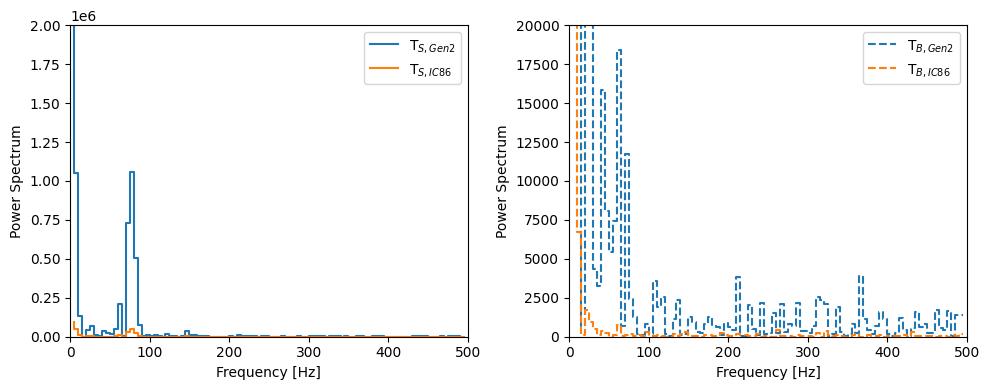

In [37]:
f, Sp_gen2, Sp_ic86, Bp_gen2, Bp_ic86 = signal_processing(sim, dt=dt, distance=5*u.kpc, trials=10000, return_power=True)

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].step(f, Sp_gen2[0], color = 'C0', ls = '-', label=r'T$_{S,Gen2}$')
ax[0].step(f, Sp_ic86[0], color = 'C1', ls = '-', label=r'T$_{S,IC86}$')
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_ylabel('Power Spectrum')
ax[0].set_xlim(0,500)
ax[0].set_ylim(0,2E6)
ax[1].step(f, Bp_gen2[0], color = 'C0', ls = '--', label=r'T$_{B,Gen2}$')
ax[1].step(f, Bp_ic86[0], color = 'C1', ls = '--', label=r'T$_{B,IC86}$')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Power Spectrum')
ax[1].set_xlim(0,500)
ax[1].set_ylim(0,2E4)
ax[0].legend()
ax[1].legend()
plt.tight_layout()

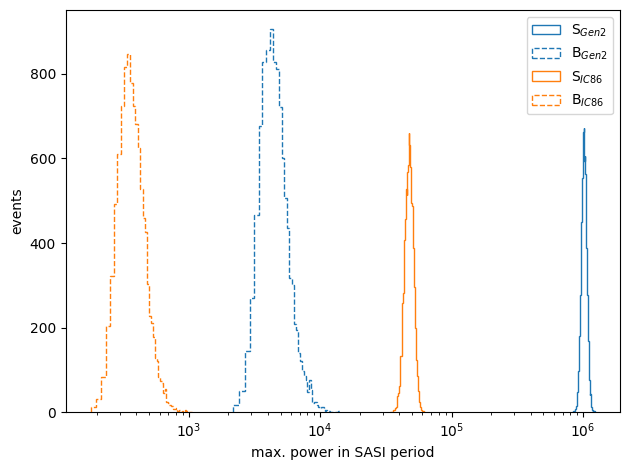

In [38]:
f, Sm_gen2, Sm_ic86, Bm_gen2, Bm_ic86 = signal_processing(sim, dt=dt, distance=5*u.kpc, trials=10000, return_max_power=True)
plt.hist(Sm_gen2, bins = 50, histtype='step', color = 'C0', ls = '-', label=r'S$_{Gen2}$')
plt.hist(Bm_gen2, bins = 50, histtype='step', color = 'C0', ls = '--', label=r'B$_{Gen2}$')
plt.hist(Sm_ic86, bins = 50, histtype='step', color = 'C1', ls = '-', label=r'S$_{IC86}$')
plt.hist(Bm_ic86, bins = 50, histtype='step', color = 'C1', ls = '--', label=r'B$_{IC86}$')
plt.xlabel('max. power in SASI period')
plt.ylabel('events')
#plt.xlim(0,100)
plt.xscale('log')
plt.legend()
plt.tight_layout()

In [13]:
distances = np.arange(1,21,1) * u.kpc
trials = 10000
Sm_gen2, Sm_ic86, Bm_gen2, Bm_ic86, Z_gen2, Z_ic86 = [], [], [], [], [], []
for d in distances:
    print('distance {:.0f}'.format(d))
    t, sm_gen2, sm_ic86, bm_gen2, bm_ic86 = signal_processing(sim, dt=dt, distance=d, trials=trials,
                                                              return_max_power=True)
    z_gen2, z_ic86 =  signal_processing(sim, dt=dt, distance=d, trials=trials, return_significance=True)
    Sm_gen2.append([sm_gen2.mean(), sm_gen2.std()])
    Sm_ic86.append([sm_ic86.mean(), sm_ic86.std()])
    Bm_gen2.append([bm_gen2.mean(), bm_gen2.std()])
    Bm_ic86.append([bm_ic86.mean(), bm_ic86.std()])
    Z_gen2.append(z_gen2)
    Z_ic86.append(z_ic86)
    
Sm_gen2 = np.array(Sm_gen2)
Sm_ic86 = np.array(Sm_ic86)
Bm_gen2 = np.array(Bm_gen2)
Bm_ic86 = np.array(Bm_ic86)
Z_gen2 = np.array(Z_gen2)
Z_ic86 = np.array(Z_ic86)

distance 1 kpc
distance 2 kpc
distance 3 kpc
distance 4 kpc
distance 5 kpc
distance 6 kpc
distance 7 kpc
distance 8 kpc
distance 9 kpc
distance 10 kpc
distance 11 kpc
distance 12 kpc
distance 13 kpc
distance 14 kpc
distance 15 kpc
distance 16 kpc
distance 17 kpc
distance 18 kpc
distance 19 kpc
distance 20 kpc


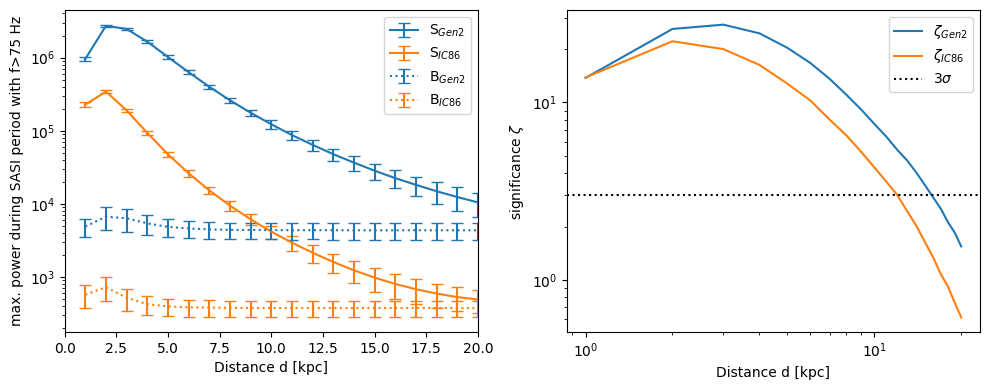

In [14]:
fig, ax = plt.subplots(1,2, figsize = (10,4))

ax[0].errorbar(x=distances, y=Sm_gen2.T[0],yerr=Sm_gen2.T[1], capsize=4, color = 'C0', label=r'S$_{Gen2}$')
ax[0].errorbar(x=distances, y=Sm_ic86.T[0],yerr=Sm_ic86.T[1], capsize=4, color = 'C1', label=r'S$_{IC86}$')
ax[0].errorbar(x=distances, y=Bm_gen2.T[0],yerr=Bm_gen2.T[1], capsize=4, color = 'C0', ls = ':', label=r'B$_{Gen2}$')
ax[0].errorbar(x=distances, y=Bm_ic86.T[0],yerr=Bm_ic86.T[1], capsize=4, color = 'C1', ls = ':', label=r'B$_{IC86}$')
ax[0].set_xlabel('Distance d [kpc]')
ax[0].set_ylabel('max. power during SASI period with f>{:.0f}'.format(cut_freq))
ax[0].set_xlim((0,20))
ax[0].set_yscale('log')
ax[0].legend()

ax[1].plot(distances, Z_gen2, color = 'C0', label=r'$\zeta_{Gen2}$')
ax[1].plot(distances, Z_ic86, color = 'C1', label=r'$\zeta_{IC86}$')
ax[1].axhline(3, color='k', ls = ':', label = '3$\sigma$')
ax[1].set_xlabel('Distance d [kpc]')
ax[1].set_ylabel('significance $\zeta$')
#ax[1].set_xlim((0,20))
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].legend()
if include_wls:
    plt.savefig('results_frequency_IC86+Gen2+WLS_{:.0E}_trials.png'.format(trials))
else:
    plt.savefig('results_frequency_IC86+Gen2_{:.0E}_trials.png'.format(trials))

plt.tight_layout()

In [15]:
import pickle
data = [distances, Sm_gen2, Sm_ic86, Bm_gen2, Bm_ic86, Z_gen2, Z_ic86]
if include_wls:
    file = open('results_frequency_IC86+Gen2+WLS_{:.0E}_trials.pkl'.format(trials), 'wb')
else:
    file = open('results_frequency_IC86+Gen2_{:.0E}_trials.pkl'.format(trials), 'wb')
pickle.dump(data,file)